* ## Data Preparation ##

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
data=pd.read_csv('../Data/Bank Customer Churn Prediction.csv')
data.head(10)

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,15574012,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,15592531,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,15656148,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,15792365,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,15592389,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


In [3]:
data.drop(columns=['customer_id'],axis=1,inplace=True)

In [4]:
data.shape

(10000, 11)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   country           10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  int64  
 5   balance           10000 non-null  float64
 6   products_number   10000 non-null  int64  
 7   credit_card       10000 non-null  int64  
 8   active_member     10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  churn             10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


## Find Outliers ##

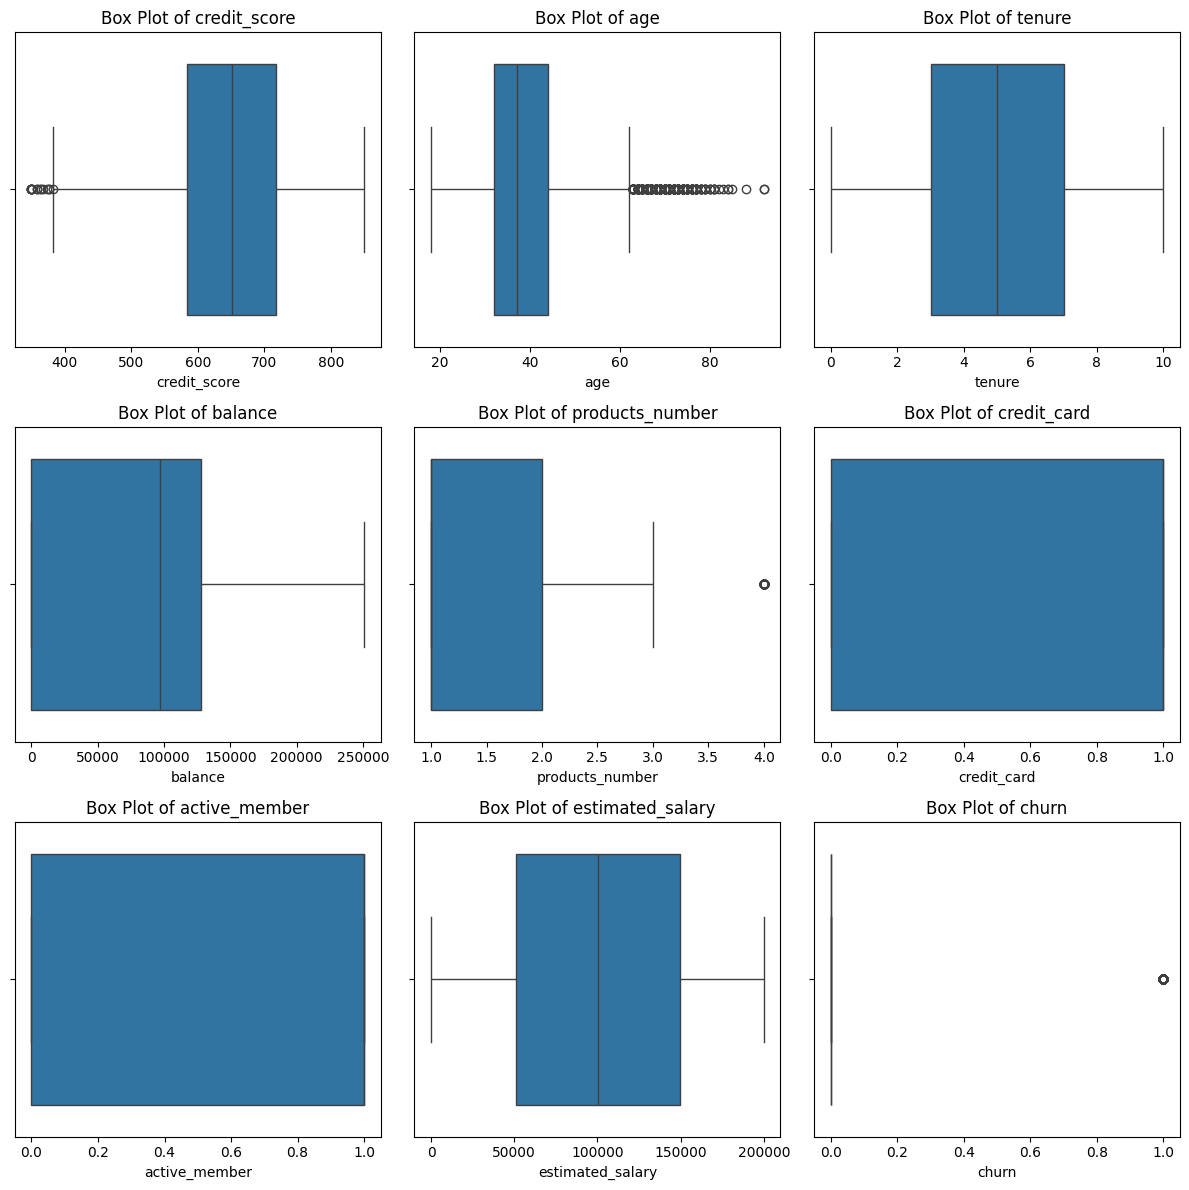

In [6]:
# Set the number of rows and columns for subplots
num_columns = len(data.select_dtypes(include=['float64', 'int64']).columns)
nrows = (num_columns // 3) + (num_columns % 3 > 0)  # Calculate required number of rows

# Set the figure size
plt.figure(figsize=(12, 4 * nrows))  # Adjust height based on the number of rows

# Create box plots for each numerical column
for i, column in enumerate(data.select_dtypes(include=['float64', 'int64']).columns):
    plt.subplot(nrows, 3, i + 1)  # Create a grid of subplots
    sns.boxplot(x=data[column])  # Box plot for the current column
    plt.title(f'Box Plot of {column}')
    plt.xlabel(column)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [7]:
# Check the class distribution before augmentation
print("class distribution before augmentation: ")
print(data['churn'].value_counts())

class distribution before augmentation: 
churn
0    7963
1    2037
Name: count, dtype: int64


In [8]:
num_col = data.select_dtypes(include = [np.number])
cat_col = data.select_dtypes(exclude = [np.number])

In [9]:
import pandas as pd
print("Data Shape:", data.shape)
# Create a copy of the data to preserve the original
data_cleaned = data.copy()

for col in num_col:
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = data_cleaned[col].quantile(0.25)
    Q3 = data_cleaned[col].quantile(0.75)

    # Calculate Interquartile Range (IQR)
    IQR = Q3 - Q1

    # Define lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = ((data_cleaned[col] < lower_bound) | (data_cleaned[col] > upper_bound)).sum()

    # Calculate total number of data points
    total_points = data_cleaned[col].shape[0]

    # Print the number and percentage of outliers
    print(f"Total Outliers in {col}: {outliers} -- {round(100 * (outliers / total_points), 2)}%")


Data Shape: (10000, 11)
Total Outliers in credit_score: 15 -- 0.15%
Total Outliers in age: 359 -- 3.59%
Total Outliers in tenure: 0 -- 0.0%
Total Outliers in balance: 0 -- 0.0%
Total Outliers in products_number: 60 -- 0.6%
Total Outliers in credit_card: 0 -- 0.0%
Total Outliers in active_member: 0 -- 0.0%
Total Outliers in estimated_salary: 0 -- 0.0%
Total Outliers in churn: 2037 -- 20.37%


## Data Augmentation ##

In [32]:
# !pip install imbalanced-learn

In [10]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Define features and target
X = data.drop(columns=['churn'])  # Exclude customer_id and target column
y = data['churn']

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Apply One-Hot Encoding on the 'country' column
country_encoded = encoder.fit_transform(X[['country']])

# Create a DataFrame with the encoded columns
country_encoded_df = pd.DataFrame(country_encoded, columns=encoder.get_feature_names_out(['country']))

# Drop the original 'country' column and concatenate the encoded columns
X = X.drop(columns=['country'])
X = pd.concat([X.reset_index(drop=True), country_encoded_df.reset_index(drop=True)], axis=1)

# Initialize LabelEncoder for 'gender' column
label_encoder = LabelEncoder()

# Fit and transform the 'gender' column
X['gender'] = label_encoder.fit_transform(X['gender'])

# Create a SMOTE object
smote = SMOTE(random_state=42)

# Fit and resample the dataset
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert back to DataFrame for easier handling
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['churn'] = y_resampled

# --- Reverse One-Hot Encoding ---
# Identify the columns corresponding to the one-hot encoding
country_columns = encoder.get_feature_names_out(['country'])

# Select only the country columns for inverse transform
country_values_to_revert = df_resampled[country_columns].values

# Use inverse_transform to get the original country values back
original_country_values = encoder.inverse_transform(country_values_to_revert)

# Assign the original country values back to the 'country' column
df_resampled['country'] = pd.Series(original_country_values.flatten())  # Avoid flatten if multi-dimensional output

# Drop the one-hot encoded columns as we have the original 'country' column now
df_resampled = df_resampled.drop(columns=country_columns)

# --- Reverse Label Encoding for Gender ---
# Inverse transform the gender column to original values
df_resampled['gender'] = label_encoder.inverse_transform(df_resampled['gender'])

# Check the class distribution after augmentation
print("class distribution after augmentation: ")
print(df_resampled['churn'].value_counts())

class distribution after augmentation: 
churn
1    7963
0    7963
Name: count, dtype: int64


In [11]:
data = df_resampled
data

,credit_score,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,country
0,619,Female,42,2,0.000000,1,1,1,101348.880000,1,France
1,608,Female,41,1,83807.860000,1,0,1,112542.580000,0,Spain
2,502,Female,42,8,159660.800000,3,1,0,113931.570000,1,France
3,699,Female,39,1,0.000000,2,0,0,93826.630000,0,France
4,850,Female,43,2,125510.820000,1,1,1,79084.100000,0,Spain
...,...,...,...,...,...,...,...,...,...,...,...
15921,773,Female,47,5,108732.431561,1,1,0,184555.335538,1,Germany
15922,465,Female,56,7,127070.846317,1,1,0,51834.800300,1,Germany
15923,603,Female,32,3,102755.340078,2,0,0,189755.014496,1,Germany
15924,732,Female,47,5,0.000000,3,1,0,89933.242727,1,France


In [12]:
data.shape

(15926, 11)

## Handling Outliers ##

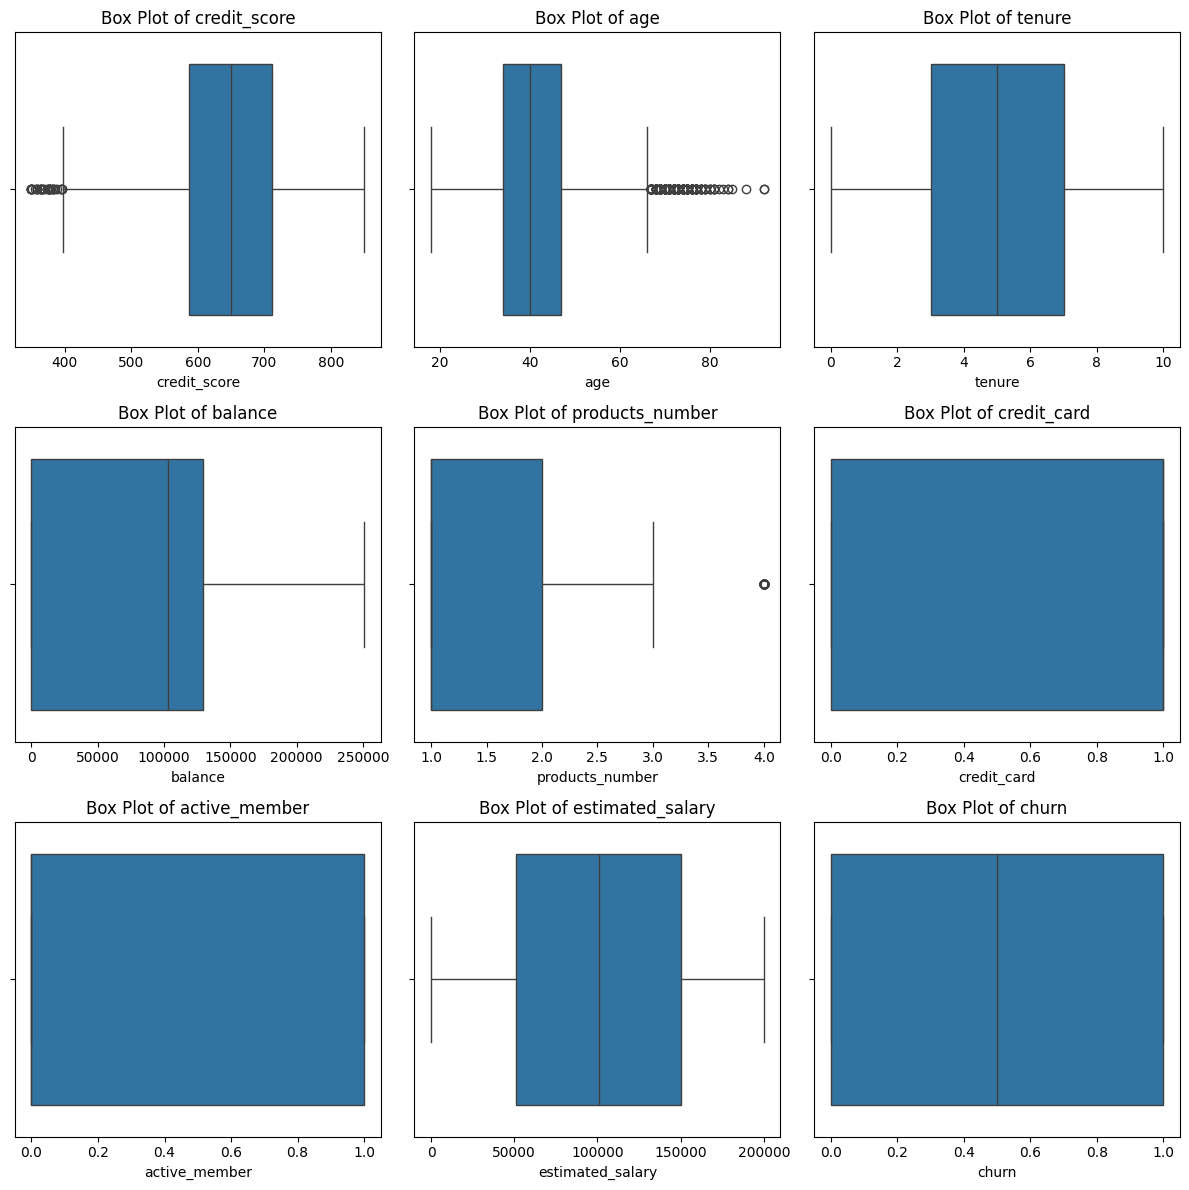

In [13]:
# Set the number of rows and columns for subplots
num_columns = len(data.select_dtypes(include=['float64', 'int64']).columns)
nrows = (num_columns // 3) + (num_columns % 3 > 0)  # Calculate required number of rows

# Set the figure size
plt.figure(figsize=(12, 4 * nrows))  # Adjust height based on the number of rows

# Create box plots for each numerical column
for i, column in enumerate(data.select_dtypes(include=['float64', 'int64']).columns):
    plt.subplot(nrows, 3, i + 1)  # Create a grid of subplots
    sns.boxplot(x=data[column])  # Box plot for the current column
    plt.title(f'Box Plot of {column}')
    plt.xlabel(column)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [14]:
num_col = data.select_dtypes(include = [np.number])
cat_col = data.select_dtypes(exclude = [np.number])

In [15]:
import pandas as pd
print("Data Shape:", data.shape)
# Create a copy of the data to preserve the original
data_cleaned = data.copy()

for col in num_col:
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = data_cleaned[col].quantile(0.25)
    Q3 = data_cleaned[col].quantile(0.75)

    # Calculate Interquartile Range (IQR)
    IQR = Q3 - Q1

    # Define lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = ((data_cleaned[col] < lower_bound) | (data_cleaned[col] > upper_bound)).sum()

    # Calculate total number of data points
    total_points = data_cleaned[col].shape[0]

    # Print the number and percentage of outliers
    print(f"Total Outliers in {col}: {outliers} -- {round(100 * (outliers / total_points), 2)}%")

    # Remove outliers for the current column
    if outliers > 0:
        data_cleaned = data_cleaned.loc[(data_cleaned[col] <= upper_bound) & (data_cleaned[col] >= lower_bound)]

# The cleaned data without outliers
print("Cleaned Data Shape:", data_cleaned.shape)


Data Shape: (15926, 11)
Total Outliers in credit_score: 34 -- 0.21%
Total Outliers in age: 253 -- 1.59%
Total Outliers in tenure: 0 -- 0.0%
Total Outliers in balance: 0 -- 0.0%
Total Outliers in products_number: 64 -- 0.41%
Total Outliers in credit_card: 0 -- 0.0%
Total Outliers in active_member: 0 -- 0.0%
Total Outliers in estimated_salary: 0 -- 0.0%
Total Outliers in churn: 0 -- 0.0%
Cleaned Data Shape: (15575, 11)


In [16]:
data = data_cleaned

In [17]:
data.shape

(15575, 11)

### Use Pycaret To get better Algorithm for dataset ###

In [16]:
# from pycaret.classification import *

# # Step 1: Setup PyCaret
# clf_setup = setup(data=data, 
#                   target='Churn', 
#                   session_id=42, 
#                   normalize=True, 
#                   categorical_features=['country',	'gender'])

# best_model = compare_models()

# tuned_model = tune_model(best_model)

# evaluate_model(tuned_model)

# predictions = predict_model(tuned_model)

# save_model(tuned_model, 'best_churn_model')

In [18]:
x = data.drop(columns=['churn'], axis=1) #Feature
y = data['churn'] #Target
x.head()

,credit_score,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,country
0,619,Female,42,2,0.00,1,1,1,101348.88,France
1,608,Female,41,1,83807.86,1,0,1,112542.58,Spain
2,502,Female,42,8,159660.80,3,1,0,113931.57,France
3,699,Female,39,1,0.00,2,0,0,93826.63,France
4,850,Female,43,2,125510.82,1,1,1,79084.10,Spain


In [19]:
X = pd.get_dummies(x, columns=['country','gender','products_number'])

X.head()

,credit_score,age,tenure,balance,credit_card,active_member,estimated_salary,country_France,country_Germany,country_Spain,gender_Female,gender_Male,products_number_1,products_number_2,products_number_3
0,619,42,2,0.00,1,1,101348.88,True,False,False,True,False,True,False,False
1,608,41,1,83807.86,0,1,112542.58,False,False,True,True,False,True,False,False
2,502,42,8,159660.80,1,0,113931.57,True,False,False,True,False,False,False,True
3,699,39,1,0.00,0,0,93826.63,True,False,False,True,False,False,True,False
4,850,43,2,125510.82,1,1,79084.10,False,False,True,True,False,True,False,False


In [34]:
X.shape , y.shape

((15575, 15), (15575,))

## Standarizing Data ##

In [20]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

# Define features and target
X = data.drop(columns=['churn'])  # Exclude the target column
y = data['churn']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Identify numeric and categorical features
numeric_features = ['credit_score','age', 'tenure', 'balance', 'products_number', 'estimated_salary']
categorical_features =  ['country', 'gender', 'credit_card', 'active_member']

# Define the numeric transformer
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),   # Impute missing values with the mean
    ('scaler', StandardScaler())                  # Standardize numeric features
])

# Define the categorical transformer
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with the most frequent category
    ('onehot', OneHotEncoder(handle_unknown='ignore',max_categories=25))     # One-hot encode categorical features
])

# Combine the transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

* ## Modelling ##

In [20]:
%load_ext tensorboard


## Gradient Boosting Classifier ##

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE

# Apply SMOTE to handle class imbalance
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define the GBoost classifier
gboost_model = GradientBoostingClassifier(random_state=42)

# Create a pipeline that first preprocesses the data and then fits the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', gboost_model)
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__n_estimators': [200, 250],           # Number of boosting stages
    'classifier__learning_rate': [0.1, 0.15],         # Learning rate (shrinkage)
    'classifier__max_depth': [2, 4],                  # Maximum depth of trees
    'classifier__min_samples_split': [5, 3],         # Minimum samples to split a node
    'classifier__min_samples_leaf': [2, 4]            # Minimum samples in a leaf node
}

# Initialize GridSearchCV with the pipeline
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)

# Train the model using grid search
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]  # For AUC-ROC calculation

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_prob)

# Print the results
print("Optimized Accuracy:", accuracy)
print("Classification Report:\n", report)
print("AUC-ROC:", auc_roc)
print("Best Hyperparameters:", grid_search.best_params_)


Fitting 3 folds for each of 32 candidates, totalling 96 fits
Optimized Accuracy: 0.8371495827091804
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.83      0.84      2363
           1       0.83      0.84      0.84      2310

    accuracy                           0.84      4673
   macro avg       0.84      0.84      0.84      4673
weighted avg       0.84      0.84      0.84      4673

AUC-ROC: 0.9196970612967228
Best Hyperparameters: {'classifier__learning_rate': 0.15, 'classifier__max_depth': 4, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 250}


## Confusion Matrix For GBoostClassifier ##

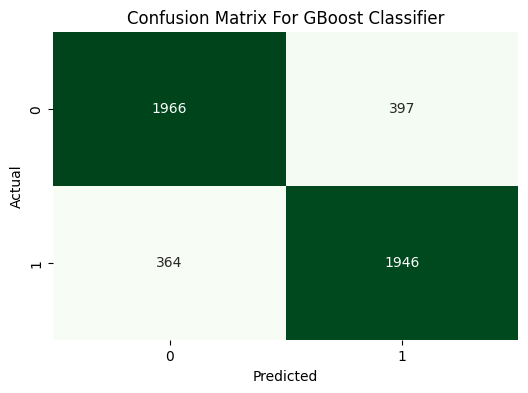

In [22]:
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import io
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Confusion Matrix For GBoost Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')

buf = io.BytesIO()  # Create a buffer to save the figure
plt.savefig(buf, format='png')  # Save the current figure to the buffer
plt.show()
plt.close()

image = tf.image.decode_png(buf.getvalue(), channels=4)
image = tf.expand_dims(image, 0)  # Add the batch dimension

In [ ]:
import datetime
import tensorflow as tf
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'logs/Models/' + current_time + '_evaluation_GBoostClassifier'
summary_writer = tf.summary.create_file_writer(log_dir)

In [ ]:
# Assuming `grid_search.best_params_` is a dictionary
best_params_str = str(grid_search.best_params_)

with summary_writer.as_default():
    tf.summary.scalar('Accuracy_GradientBoostingClassifier', accuracy, step=1)
    tf.summary.text('Best Hyperparameters', best_params_str, step=1)
    tf.summary.scalar('AUC-ROC', auc_roc, step=1)
    tf.summary.image('Confusion Matrix', image, step=1)

print(f"TensorBoard logs created at: {log_dir}")

## Logistic Regression ##

In [23]:
x = data.drop(columns=['churn'], axis=1) #Feature
y = data['churn'] #Target
x.head()

,credit_score,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,country
0,619,Female,42,2,0.00,1,1,1,101348.88,France
1,608,Female,41,1,83807.86,1,0,1,112542.58,Spain
2,502,Female,42,8,159660.80,3,1,0,113931.57,France
3,699,Female,39,1,0.00,2,0,0,93826.63,France
4,850,Female,43,2,125510.82,1,1,1,79084.10,Spain


In [24]:
X = pd.get_dummies(x, columns=['country','gender','products_number'])

X.head()

,credit_score,age,tenure,balance,credit_card,active_member,estimated_salary,country_France,country_Germany,country_Spain,gender_Female,gender_Male,products_number_1,products_number_2,products_number_3
0,619,42,2,0.00,1,1,101348.88,True,False,False,True,False,True,False,False
1,608,41,1,83807.86,0,1,112542.58,False,False,True,True,False,True,False,False
2,502,42,8,159660.80,1,0,113931.57,True,False,False,True,False,False,False,True
3,699,39,1,0.00,0,0,93826.63,True,False,False,True,False,False,True,False
4,850,43,2,125510.82,1,1,79084.10,False,False,True,True,False,True,False,False


In [25]:
X.shape, y.shape

((15575, 15), (15575,))

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr_model = LogisticRegression()

# Fit model
lr_model.fit(X_train_scaled, y_train)

# Get binary predictions
y_pred = lr_model.predict(X_test_scaled)
accuracy= accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

# AUC-ROC score, use the predicted probabilities
y_pred_prob_lr1 = lr_model.predict_proba(X_test_scaled)[:, 1]  # Get probabilities for class 1 (churn)
auc_roc_lr1 = roc_auc_score(y_test, y_pred_prob_lr1)
print("AUC-ROC:", auc_roc_lr1)


Accuracy: 0.8195826645264848
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82      1532
           1       0.82      0.82      0.82      1583

    accuracy                           0.82      3115
   macro avg       0.82      0.82      0.82      3115
weighted avg       0.82      0.82      0.82      3115

AUC-ROC: 0.9026483244789201


## Confusion Matrix for Logistic Regression ##

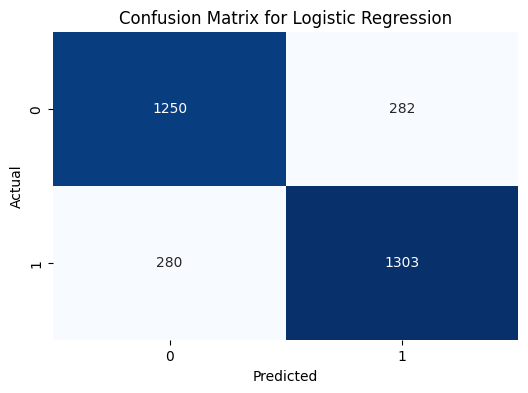

In [27]:
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import io
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')

buf = io.BytesIO()  # Create a buffer to save the figure
plt.savefig(buf, format='png')  # Save the current figure to the buffer
plt.show()
plt.close()

image = tf.image.decode_png(buf.getvalue(), channels=4)
image = tf.expand_dims(image, 0)  # Add the batch dimension


In [ ]:
import datetime
import tensorflow as tf

# Setting up TensorBoard logging
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'logs/Models/' + current_time + '_evaluation_LogisticRegression'
summary_writer = tf.summary.create_file_writer(log_dir)

In [24]:
import tensorflow as tf
# Log metrics to TensorBoard
with summary_writer.as_default():
    tf.summary.scalar('Accuracy_LogisticRegression', accuracy, step=1)
    tf.summary.scalar('AUC-ROC', auc_roc_lr1, step=1)
    tf.summary.image('Confusion Matrix', image, step=1)

print(f"TensorBoard logs created at: {log_dir}")

TensorBoard logs created at: logs/Models/20241014-020142_evaluation_LogisticRegression


In [28]:
from sklearn.metrics import confusion_matrix
y_pred = lr_model.predict(X_test_scaled)

# Compute the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

tpr = tp / (tp + fn)  # True Positive Rate (Recall)
fpr = fp / (fp + tn)
tnr = tn / (tn + fp)
fnr = fn / (fn + tp)

print(f"True Positive Rate (Recall): {tpr:.2f}")
print(f"False Positive Rate: {fpr:.2f}")
print(f"False Negative Rate (Precision): {fnr:.2f}")
print(f"True Negative Rate: {tnr:.2f}")

True Positives (TP): 1303
False Positives (FP): 282
True Negatives (TN): 1250
False Negatives (FN): 280
True Positive Rate (Recall): 0.82
False Positive Rate: 0.18
False Negative Rate (Precision): 0.18
True Negative Rate: 0.82


## Support Vector Classifier ##

In [29]:
# Feature scaling (important for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svc_model = SVC(kernel='linear', probability=True) 

svc_model.fit(X_train_scaled, y_train)

# Predict class labels on the test set
y_pred = svc_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
# Evaluate the model performance
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

y_pred_prob_svc = svc_model.predict_proba(X_test_scaled)[:, 1]
auc_roc_svc = roc_auc_score(y_test, y_pred_prob_svc)
print("AUC-ROC:", auc_roc_svc)

Accuracy: 0.8186195826645265
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82      1532
           1       0.82      0.82      0.82      1583

    accuracy                           0.82      3115
   macro avg       0.82      0.82      0.82      3115
weighted avg       0.82      0.82      0.82      3115

AUC-ROC: 0.9027015169333437


## Confusion Matrix For SVC ##

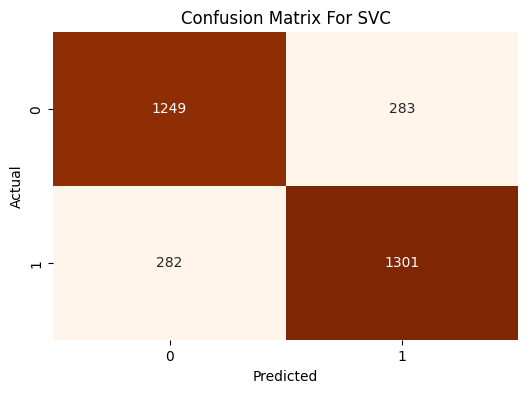

In [30]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', cbar=False)
plt.title('Confusion Matrix For SVC')
plt.xlabel('Predicted')
plt.ylabel('Actual')

buf = io.BytesIO()  # Create a buffer to save the figure
plt.savefig(buf, format='png')  # Save the current figure to the buffer
plt.show()
plt.close()

image = tf.image.decode_png(buf.getvalue(), channels=4)
image = tf.expand_dims(image, 0)  # Add the batch dimension

In [28]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'logs/Models/' + current_time + '_evaluation_SVC'
summary_writer = tf.summary.create_file_writer(log_dir)
# Log metrics to TensorBoard
with summary_writer.as_default():
    tf.summary.scalar('Accuracy_SupportVectorClassifier', accuracy, step=1)
    tf.summary.scalar('AUC-ROC', auc_roc_svc, step=1)
    tf.summary.image('Confusion Matrix', image, step=1)

print(f"TensorBoard logs created at: {log_dir}")

TensorBoard logs created at: logs/Models/20241014-020155_evaluation_SVC


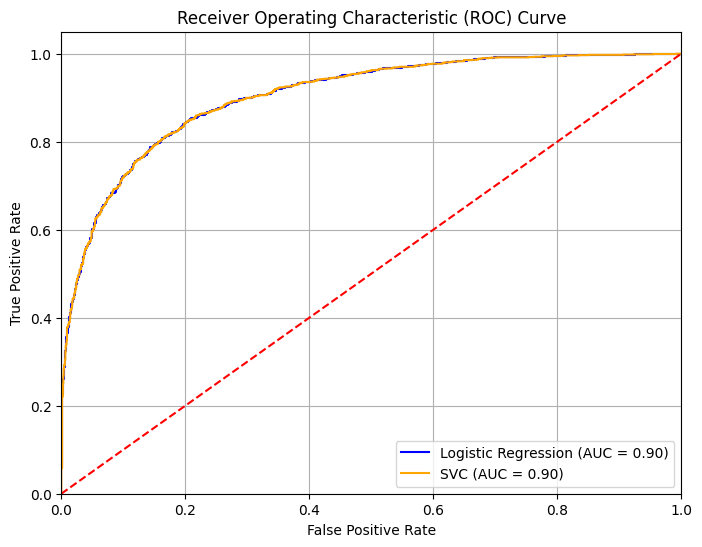

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Compute ROC curve and AUC for Logistic Regression
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_lr1)
roc_auc = roc_auc_score(y_test, y_pred_prob_lr1)

# Compute ROC curve and AUC for SVC
fpr_svc, tpr_svc, _ = roc_curve(y_test, y_pred_prob_svc)
roc_auc_svc = roc_auc_score(y_test, y_pred_prob_svc)

# Plot ROC curves
plt.figure(figsize=(8, 6))

# ROC for Logistic Regression
plt.plot(fpr, tpr, color='blue', label=f'Logistic Regression (AUC = {roc_auc:.2f})')

# ROC for SVC
plt.plot(fpr_svc, tpr_svc, color='Orange', label=f'SVC (AUC = {roc_auc_svc:.2f})')

# Diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()

plt.show()

In [2]:
%reload_ext tensorboard
%tensorboard --logdir logs
# run these in terminal to show the board
# tensorboard --logdir=Machine_Learning/logs/Models

Reusing TensorBoard on port 6006 (pid 35256), started 8 days, 16:07:25 ago. (Use '!kill 35256' to kill it.)